# Laboratorium 9

### 0. Wczytanie danych
Używając metody `load_svmlight_file` z modułu `sklearn` załaduj plik `lab13_files/breast_cancer`, który składa się z 2 elementów: macierzy `X` o wymiarach `683 x 10` oraz wektora `y` o dlugosci `683`. Macierz `X` opisuje badania 683 pacjentow, a wektor `y` ich diagnozy. 

In [182]:
from sklearn.datasets import load_svmlight_file
import numpy as np
import matplotlib.pyplot as plt

X, y = load_svmlight_file('breast-cancer')
X = X.toarray()

### 1. Preprocessing
1.1 Korzystajac z `numpy.where` przenumeruj wektor y, tzn zamień wartości 2 i 4 na -1 i +1.

1.2 Przeskaluj macierz X, tak żeby wartości w każdej kolumnie mieściły się w zakresie [0,1], innymi słowy przeskaluj niezależnie każdą kolumne $X_j$ wg wzoru:


$$
X_j = \frac{X_j-\min(X_j)}{\max(X_j)-\min(X_j)}
$$

In [183]:
y = np.where(y == 2, -1, 1)
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

### 2. Wizualizacja
Narysuj dane używajac biblioteki `matplotlib`. Użyj wymiarów 1 i 2 z macierzy X, a jako kolory użyj wektora y. Pobaw sie parametrami "s" oraz "alpha" metody `plt.scatter` żeby uzyskać czytelną wizualizacje, np. taką jak poniżej.

<img src="lab13_files/d.png">

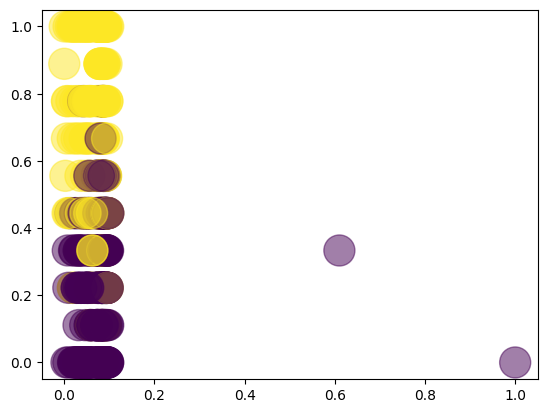

In [184]:
plt.scatter(X[:,0], X[:,1], c = y, alpha=0.5, s=500)

### 3. Regresja 

Przeprowadź regresje liniową wg wzoru:
$$
\beta = (X^TX)^{-1}X^Ty
$$

In [185]:
X_transpose = np.transpose(X)

# (X^T * X)^-1
t1 = np.linalg.inv(np.dot(X_transpose, X))

# X^T * y
t2 = np.dot(X_transpose, y)

beta = np.dot(t1, t2)


### 4. Wizualizacja Regresji

Zwizualizuj dane po zrzutowaniu na $\beta$ używajac metody `plt.hist`, tzn. narysuj histogramy $\beta X_+$ oraz
$\beta X_-$ gdzie $X_+$ to wiersze $X$ dla których $y=+1$ i analogicznie $X_-$. Postaraj się wygenerować czytelny wykres podobny do tego poniżej.

<img src="lab13_files/lr1.png">

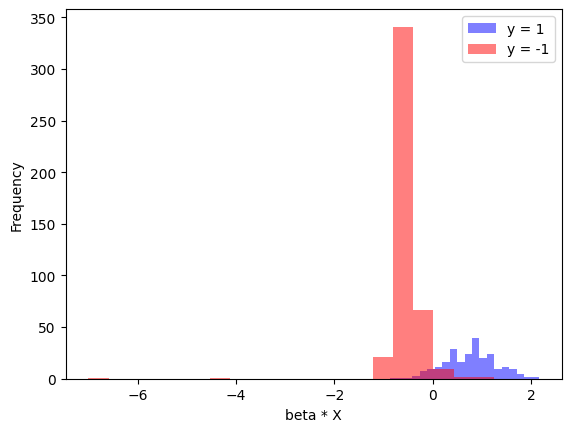

In [186]:
X_plus = X[y == 1]
X_minus = X[y == -1]

beta_X_plus = np.dot(X_plus, beta)
beta_X_minus = np.dot(X_minus, beta)

plt.hist(beta_X_plus, bins=20, color='blue', alpha=0.5, label='y = 1')
plt.hist(beta_X_minus, bins=20, color='red', alpha=0.5, label='y = -1')
plt.legend()
plt.xlabel('beta * X')
plt.ylabel('Frequency')
plt.show()


### 5. Klasyfikacja

Przeprowadź "klasyfikacje" naszych pacjentów, ci, którzy zostali zrzutowani na wartość ujemną dostają etykiete $-1$, a ci którzy na wartość dodatnia - etykiete $+1$

In [187]:
beta_X = np.dot(X, beta)
y_pred = np.where(beta_X < 0, -1, 1)


### 6. Ewaluacja

Policz jak dokładny jest ten model, tzn. jak duży jest zbiór
$ \{ (x_i,y_i) : \mathrm{sign}(\beta x_i) = y_i \} $
w stosunku do rozmiaru całego $y$

Powinno udać się uzyskać wynik na poziomie 93-94%

In [188]:
accuracy = np.mean(y_pred == y)
accuracy

0.9487554904831625

### 7. Regularyzacja 
Dodaj parametr `C` do regresji liniowej
$$
\beta = (X^TX + \tfrac{1}{C}I)^{-1}X^Ty
$$

gdzie $I$ - macierz identyczności. 

Dla jakiej wartości `C` wynik jest najlepszy? Jaki wynik udało Ci sie uzyskać?

In [189]:
C = 0.1

I = np.identity(X.shape[1])
t1 = np.linalg.inv(np.dot(X_transpose, X) + (1/C)*I)
beta = np.dot(t1, t2)

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
grid_search.fit(X, y)

best_c = grid_search.best_params_['alpha']
best_accuracy = grid_search.best_score_

print("C:", best_c)
print("Wynik:", best_accuracy)

C: 10
Wynik: 0.8237097790329884


### 8. Gratulacje
Właśnie stworzyłeś/-aś swój pierwszy klasyfikator (statystyczny model predykcji). 

Spróbuj zastosować go do innych danych.

### Zadanie dodatkowe

Zaimplementuj powyższą metode jako klase `LRClassifier` wyposażoną w następujące metody:

* konstruktor przyjmujący dwa parametry: 
    * `C` - stała z równania 
    * `scale` - zmienna boolowska (domyslnie `True`) która określa czy macierz `X` ma byc automatycznie znormalizowana (przeskalowana do `[0,1]`)
* `.fit(X, y)` która spowoduje obliczenie $\beta$, dla `X` - dowolnej macierzy, `y` - wektora etykiet skladajacego sie z dwóch unikalnych wartosci (mogą to byc np. 2 różne stringi)
* `.predict(X)`, która zwróci wektor zawierajacy na `i`tej pozycji etykiete "przewidzianą" przez nasz model (pamiętaj o skalowaniu jesli `scale==True`!)

Przykladowe użycie:

    clf = LRClassifier(C=100)
    Xt = np.array([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4]])
    yt = np.array(['x', 'x', 'y', 'y', 'y'])
    clf.fit(Xt, yt)
    X = np.array([[1, -1], [1, 0.9], [1, 2.1]])
    print(clf.predict(X)) # ['x', 'x', 'y']

In [190]:
import numpy as np
import pandas as pd

class LRClassifier:
    def __init__(self, C=1.0, scale=True):
        self.C = C
        self.scale = scale
        self.beta = None

    def fit(self, X, y):
        y=pd.get_dummies(y)
        if self.scale:
            range = X.max(axis=0) - X.min(axis=0)
            range[range == 0] = 1
            X = (X - X.min(axis=0)) / range
        I = np.identity(X.shape[1])
        temp1 = np.linalg.inv(X.T.dot(X) + (1/self.C)*I)
        temp2 = X.T.dot(y)
        self.beta = temp1.dot(temp2)


    def predict(self, X):
        if self.scale:
            range = X.max(axis=0) - X.min(axis=0)
            range[range == 0] = 1
            X = (X - X.min(axis=0)) / range
        y_pred = np.where(X.dot(self.beta) < 0, -1, 1)
        return y_pred



In [191]:
clf = LRClassifier(C=100)
Xt = np.array([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4]])
yt = np.array(['x', 'x', 'y', 'y', 'y'])
clf.fit(Xt, yt)
X = np.array([[1, -1], [1, 0.9], [1, 2.1]])
print(clf.predict(X)) # ['x', 'x', 'y']

[[1 1]
 [1 1]
 [1 1]]
